# Integral Equation Model Comparisons
Purpose of this notebook is to EOS calculations for comparisons to George Petrov's Average Atom model, and Morales EOS Hydrogen paper

[https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


#### Load George Data

In [2]:
GP_H_file = "H-rho=1.dat"
GP_df = read_csv(GP_H_file, delim_whitespace=True, header=0)
GP_PMbar_1 = GP_df['P_ishikawa'][3:]
GP_PMbar_2 = GP_df['P_fauss'][3:]
GP_Te_eV = GP_df['Te'][3:]

In [3]:
GP_df

,Te,eta,Ne_b,Ne_quasi,Ne_sc,Z,mu,nu_mom,nu_tot,sigma,k_th,L,U,G,P_ishikawa,P_fauss
0,0.1,1.0,0.0,0.0,1.0,1.0,0.60830,0.112600,0.44460,0.3495,0.004226,3.290,0.027324,1.235000e-05,0.6827,2.898
1,0.2,1.0,0.0,0.0,1.0,1.0,0.60960,0.111800,0.44000,0.3526,0.008530,3.291,0.027421,1.231000e-05,0.7285,2.935
2,0.5,1.0,0.0,0.0,1.0,1.0,0.61320,0.109700,0.42720,0.3618,0.021930,3.298,0.027736,1.221000e-05,0.8676,3.051
3,1.0,1.0,0.0,0.0,1.0,1.0,0.61840,0.106800,0.40890,0.3765,0.045970,3.323,0.028337,1.207000e-05,1.1070,3.249
4,2.0,1.0,0.0,0.0,1.0,1.0,0.62610,0.102800,0.38020,0.4044,0.101200,3.404,0.029878,1.190000e-05,1.6300,3.687
5,5.0,1.0,0.0,0.0,1.0,1.0,0.62760,0.099500,0.32790,0.4783,0.311000,3.539,0.037150,1.198000e-05,3.6120,5.376
6,10.0,1.0,0.0,0.0,1.0,1.0,0.54060,0.101800,0.28640,0.5767,0.821000,3.874,0.053984,1.215000e-05,7.5520,8.886
7,20.0,1.0,0.0,0.0,1.0,1.0,0.09214,0.103100,0.24640,0.8232,2.499000,4.130,0.094795,1.116000e-05,16.1800,16.890
8,50.0,1.0,0.0,0.0,1.0,1.0,-2.42900,0.088140,0.19200,1.9690,13.760000,3.803,0.232150,7.608000e-06,43.2700,43.670
9,100.0,1.0,0.0,0.0,1.0,1.0,-8.66900,0.063270,0.14550,4.4600,61.560000,3.756,0.471360,4.457000e-06,89.7400,89.970


#### Load Morales Data

In [4]:
Morales_file = "Morales_EOS_data.dat"
Morales_df = read_csv(Morales_file, delim_whitespace=True, header=4)
Morales_EAU  = Morales_df['E[AU]']
Morales_PGPa = Morales_df['P[GPa]']
Morales_TK   = Morales_df['T[K]']
Morales_PMbar =  1e-2*Morales_PGPa
Morales_TeV = Morales_TK/eV_to_K

In [5]:
Morales_df

,T[K],ρgpercc,rs,E[AU],P[GPa]
0,2000,0.983,1.4,-0.5117,213
1,3000,0.983,1.4,-0.5057,220
2,4000,0.983,1.4,-0.4993,232
3,6000,0.983,1.4,-0.4869,256
4,8000,0.983,1.4,-0.4767,275
5,10000,0.983,1.4,-0.4674,295


#### Load atoMEC data

In [6]:
atoMEC_file = "atoMEC_H_pressures.dat"
atoMEC_df = read_csv(atoMEC_file, delim_whitespace=True, header=0)
atoMEC_TeV = atoMEC_df['T[eV]']
atoMEC_PAU = atoMEC_df['P[AU]']
atoMEC_PMbar = atoMEC_PAU*AU_to_bar/1e6
atoMEC_df

,T[eV],P[AU]
0,0.172347,0.004035
1,0.258520,0.004043
2,0.344693,0.004054
3,0.517040,0.004084
4,0.689386,0.004127
5,0.861733,0.004182
6,1.000000,0.004235
7,2.000000,0.004849
8,5.000000,0.008853
9,10.000000,0.019958


### Set Parameters in Paper and Plot

In [7]:
name = 'Hydrogen'
Z, A = 1,1 

Te_eV_list = np.geomspace(np.min(Morales_TeV), np.max(GP_Te_eV), num=15) #np.array(GP_Te_eV) # eV
Ti_eV_list = Te_eV_list
ni_cc = 5.98e23
ni_AU = ni_cc/cm_to_AU**3

ri_cm = rs_from_n(ni_cc)  # cm
ri_AU = ri_cm*cm_to_AU    # AU 

In [8]:
ri_AU

1.3914542638521432

In [9]:
from hnc.hnc.misc import Degeneracy_Parameter, find_η, P_Ideal_Fermi_Gas, Fermi_Energy

np.array([P_Ideal_Fermi_Gas(Te, ni_AU) for Te in Te_eV_list*eV_to_AU])*AU_to_bar/1e6

array([   9.92099106,    9.926066  ,    9.94538199,   10.01867366,
         10.29382884,   11.27418571,   14.24759619,   21.59603589,
         37.47601859,   69.72379761,  133.59938263,  258.93443737,
        504.00369643,  982.57296292, 1916.67816283])

In [10]:
np.sqrt((2/5 * Fermi_Energy(ni_AU)/(4/3*π*ri_AU**3) * AU_to_bar/1e6 )**2+( Te_eV_list*eV_to_AU*ni_AU* AU_to_bar/1e6)**2)

array([   9.92055719,    9.92441527,    9.93909189,    9.9947786 ,
         10.20403482,   10.96432281,   13.47209879,   20.36753499,
         36.10149733,   68.45711493,  132.54432755,  258.1030081 ,
        503.36959176,  982.0991122 , 1916.3265231 ])

#### Run Ornstein-Zernike Closure

In [11]:
def plasma_output(plasma):
    plasma.run_hnc()
    try: 
        plasma.hnc.βu_r_matrix[1,1] -= plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] -= plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    Pe_hnc_id, Pe_hnc_ex   = plasma.hnc.rho[1]*plasma.hnc.Temp_list[1],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[1] 
    try: 
        plasma.hnc.βu_r_matrix[1,1] += plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] += plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    
    Pe_Mbar_id, Pe_Mbar_ex = P_hnc_to_Mbar(Pe_hnc_id), P_hnc_to_Mbar(Pe_hnc_ex)
    Pe_Mbar = Pe_Mbar_id + Pe_Mbar_ex
    return Pe_Mbar_id, Pe_Mbar_ex, Pe_Mbar

name1 = 'OZ - g'
plasma1 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name2 = 'OZ - th'
plasma2 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name3 = 'OZ - th  Pauli'
plasma3 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name4 = 'SVT - th'
plasma4 =  lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'svt'},
                 hnc_solve_options={'alpha_Picard':0.5,'num_iterations':1e4})

P_hnc_to_bar = lambda P_hnc: (P_hnc/ri_AU**3) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc: 1e-6*P_hnc_to_bar(P_hnc)
P_hnc_to_GPa = lambda P_hnc:  P_hnc_to_bar(P_hnc) * 1e5 / 1e9 

####  Investigate Pressure 

In [12]:
# print("P = {0:.3e} [Mbar]".format(P_hnc_to_Mbar(Pid)))
# print("P = {0:.3e} [GPa]".format(P_hnc_to_GPa(Pid)))

### Compute all plasma models for list of densities

In [14]:
P_list_1 = []
P_list_2 = []
P_list_3 = []
P_list_4 = []

for T_eV in Te_eV_list:
    #1
    # plasma = plasma1(T_eV)
    # Pe_id, Pe_ex, Pe = plasma_output(plasma)
    # P_list_1.append( [Pe_id, Pe_ex, Pe] )
    #2
    # plasma = plasma2(T_eV)
    # Pe_id, Pe_ex, Pe = plasma_output(plasma)
    # P_list_2.append( [Pe_id, Pe_ex, Pe] )
    #3
    plasma = plasma3(T_eV)
    Pe_id, Pe_ex, Pe = plasma_output(plasma)
    P_list_3.append( [Pe_id, Pe_ex, Pe] )
    #4
    # plasma = plasma4(T_eV)
    # Pe_id, Pe_ex, Pe = plasma_output(plasma)
    # P_list_4.append( [Pe_id, Pe_ex, Pe] )
    

Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.064e+01
Exiting status 0, reverting to best index so far: 805
Final iter:806, Total Error: 9.922e-09
Te_in_eV: 0.336
Ti_in_eV: 0.336
0: Initial condition Total Error: 6.742e+00
Exiting status 0, reverting to best index so far: 453
Final iter:454, Total Error: 9.680e-09
Te_in_eV: 0.656
Ti_in_eV: 0.656
0: Initial condition Total Error: 4.187e+00
Exiting status 0, reverting to best index so far: 263
Final iter:264, Total Error: 9.382e-09
Te_in_eV: 1.281
Ti_in_eV: 1.281
0: Initial condition Total Error: 2.542e+00
Exiting status 0, reverting to best index so far: 158
Final iter:159, Total Error: 8.998e-09
Te_in_eV: 2.499
Ti_in_eV: 2.499
0: Initial condition Total Error: 1.505e+00
Exiting status 0, reverting to best index so far: 98
Final iter:99, Total Error: 8.812e-09
Te_in_eV: 4.876
Ti_in_eV: 4.876
0: Initial condition Total Error: 8.710e-01
Exiting status 0, reverting to best index so far: 63
Final iter:64, Total Error: 

/home/zach/plasma/hnc/hnc/PIE.py:182: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]


0: Initial condition Total Error: 1.697e-01
Exiting status 0, reverting to best index so far: 25
Final iter:26, Total Error: 6.994e-09
Te_in_eV: 70.693
Ti_in_eV: 70.693


/home/zach/plasma/hnc/hnc/PIE.py:182: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]


0: Initial condition Total Error: 9.567e-02
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 9.799e-09
Te_in_eV: 137.946
Ti_in_eV: 137.946
0: Initial condition Total Error: 5.353e-02
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 5.723e-09
Te_in_eV: 269.177
Ti_in_eV: 269.177
0: Initial condition Total Error: 3.260e-02
Exiting status 0, reverting to best index so far: 22
Final iter:23, Total Error: 7.523e-09
Te_in_eV: 525.253
Ti_in_eV: 525.253
0: Initial condition Total Error: 2.205e-02
Exiting status 0, reverting to best index so far: 22
Final iter:23, Total Error: 5.243e-09
Te_in_eV: 1024.942
Ti_in_eV: 1024.942
0: Initial condition Total Error: 1.497e-02
Exiting status 0, reverting to best index so far: 21
Final iter:22, Total Error: 7.148e-09
Te_in_eV: 2000.000
Ti_in_eV: 2000.000
0: Initial condition Total Error: 9.376e-03
Exiting status 0, reverting to best index so far: 20
Final iter:21, Total Error: 8.947e-09


Now Plot 

In [15]:
P_list_1 = np.array(P_list_1)
P_list_2 = np.array(P_list_2)
P_list_3 = np.array(P_list_3)
P_list_4 = np.array(P_list_4)

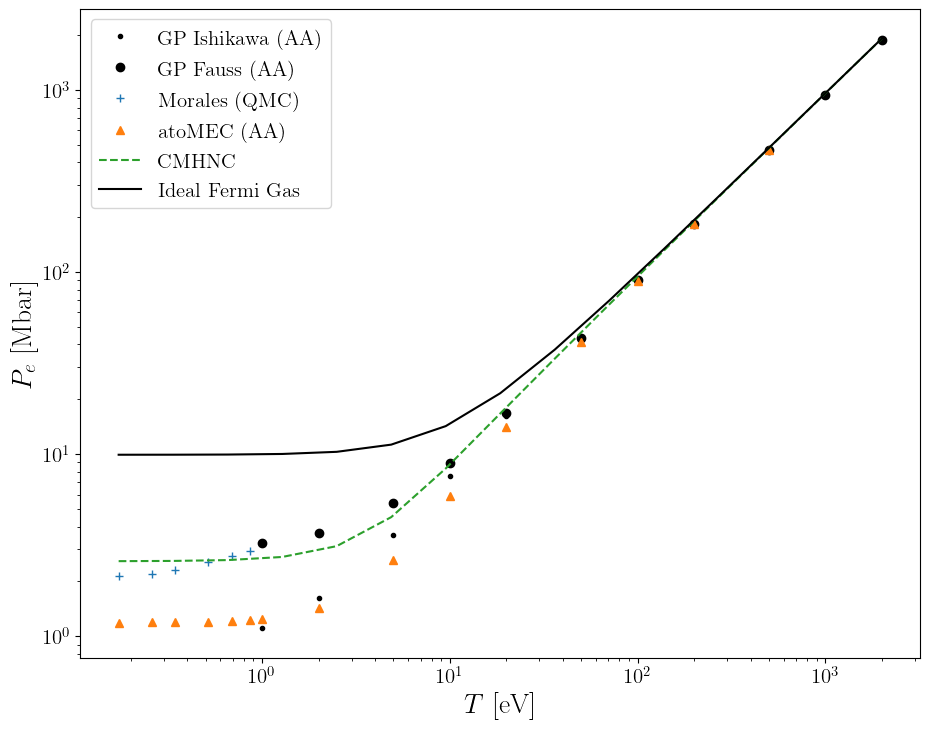

In [17]:
from hnc.hnc.misc import P_Ideal_Fermi_Gas

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot GP data 
axs[0].plot(GP_Te_eV, GP_PMbar_1, 'k.', label='GP Ishikawa (AA)')
axs[0].plot(GP_Te_eV, GP_PMbar_2, 'ko', label='GP Fauss (AA)')

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_PMbar, '+', label='Morales (QMC)')

#Plot atoMEC data
axs[0].plot(atoMEC_TeV, atoMEC_PMbar, '^', label='atoMEC (AA)')

# Plot Pressure ratio
# axs[0].plot(GP_Te_eV, P_list_1[:,2], label=name1)
# axs[0].plot(Te_eV_list, P_list_2[:,2], label=name2)
# axs[0].plot(Te_eV_list, P_list_3[:,2],'--', label=name3)
axs[0].plot(Te_eV_list, P_list_3[:,2],'--', label="CMHNC")
# axs[0].plot(Te_eV_list, P_list_4[:,2],'--.', label=name4)

# Plot Fermi Pressure
axs[0].plot(Te_eV_list, [P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_bar/1e6 for Te_eV in Te_eV_list],'k-', label="Ideal Fermi Gas"  ) 

for ax in axs:
    ax.legend(fontsize=15, loc='upper left')
    ax.set_xscale('log')
    # ax.set_yscale('symlog', linthresh=1)
    ax.set_yscale('log')
    # ax.set_ylim(0, 1e4)
    ax.set_ylabel(r"$P_e$ [Mbar]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()